In [256]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib as ta
from pylab import mpl
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score,auc,classification_report,confusion_matrix,roc_curve
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing

In [257]:
#设置LSTM的时间窗
window=1
#读取数据
df1=pd.read_csv('000001.csv',encoding='gb2312')
df1.rename(columns={'日期':'date','股票代码':'code','名称':'name','收盘价':'close','最高价':'high','最低价':'low','开盘价':'open','前收盘':'previous close','涨跌额':'change amount','涨跌幅':'change rate','成交量':'volume','成交金额':'money'},inplace=True)
df1.sort_values('date', inplace=True)
df1 = df1.reset_index(drop=True)
df1

,date,code,name,close,high,low,open,previous close,change amount,change rate,volume,money
0,1990/12/19,'000001,上证指数,99.9800,99.9800,95.7900,96.0500,99.9800,4.4100,4.4109,1260,4.940000e+05
1,1990/12/20,'000001,上证指数,104.3900,104.3900,99.9800,104.3000,99.9800,4.4100,4.4109,197,8.400000e+04
2,1990/12/21,'000001,上证指数,109.1300,109.1300,103.7300,109.0700,104.3900,4.7400,4.5407,28,1.600000e+04
3,1990/12/24,'000001,上证指数,114.5500,114.5500,109.1300,113.5700,109.1300,5.4200,4.9666,32,3.100000e+04
4,1990/12/25,'000001,上证指数,120.2500,120.2500,114.5500,120.0900,114.5500,5.7000,4.9760,15,6.000000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...
7343,2021/1/4,'000001,上证指数,3502.9584,3511.6554,3457.2061,3474.6793,3473.0693,29.8891,0.8606,380790800,5.230000e+11
7344,2021/1/5,'000001,上证指数,3528.6767,3528.6767,3484.7151,3492.1912,3502.9584,25.7183,0.7342,407995934,5.680000e+11
7345,2021/1/6,'000001,上证指数,3550.8767,3556.8022,3513.1262,3530.9072,3528.6767,22.2000,0.6291,370230926,5.220000e+11
7346,2021/1/7,'000001,上证指数,3576.2046,3576.2046,3526.6174,3552.9087,3550.8767,25.3279,0.7133,405348226,5.460000e+11


In [226]:
df1[['close','high','low','open','previous close','change amount','change rate','volume','money']] = df1[['close','high','low','open','previous close','change amount','change rate','volume','money']].astype('float32')
df1

,close,high,low,open,previous close,change amount,change rate,volume,money
0,99.980003,99.980003,95.790001,96.050003,99.980003,4.410000,4.4109,1260.0,4.940000e+05
1,104.389999,104.389999,99.980003,104.300003,99.980003,4.410000,4.4109,197.0,8.400000e+04
2,109.129997,109.129997,103.730003,109.070000,104.389999,4.740000,4.5407,28.0,1.600000e+04
3,114.550003,114.550003,109.129997,113.570000,109.129997,5.420000,4.9666,32.0,3.100000e+04
4,120.250000,120.250000,114.550003,120.089996,114.550003,5.700000,4.9760,15.0,6.000000e+03
...,...,...,...,...,...,...,...,...,...
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11


In [227]:
df1['average']=ta.AVGPRICE(df1.open,df1.high,df1.low,df1.close)
df1['median']=ta.MEDPRICE(df1.high,df1.low)
df1['typical']=ta.TYPPRICE(df1.high,df1.low,df1.close)
df1['weight']=ta.WCLPRICE(df1.high,df1.low,df1.close)
df1.head()

,close,high,low,open,previous close,change amount,change rate,volume,money,average,median,typical,weight
0,99.980003,99.980003,95.790001,96.050003,99.980003,4.41,4.4109,1260.0,494000.0,97.950003,97.885002,98.583336,98.932503
1,104.389999,104.389999,99.980003,104.300003,99.980003,4.41,4.4109,197.0,84000.0,103.265001,102.185001,102.920001,103.287500
2,109.129997,109.129997,103.730003,109.070000,104.389999,4.74,4.5407,28.0,16000.0,107.764999,106.430000,107.329999,107.779999
3,114.550003,114.550003,109.129997,113.570000,109.129997,5.42,4.9666,32.0,31000.0,112.950001,111.840000,112.743334,113.195002
4,120.250000,120.250000,114.550003,120.089996,114.550003,5.70,4.9760,15.0,6000.0,118.785000,117.400002,118.350001,118.825001


Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20854 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

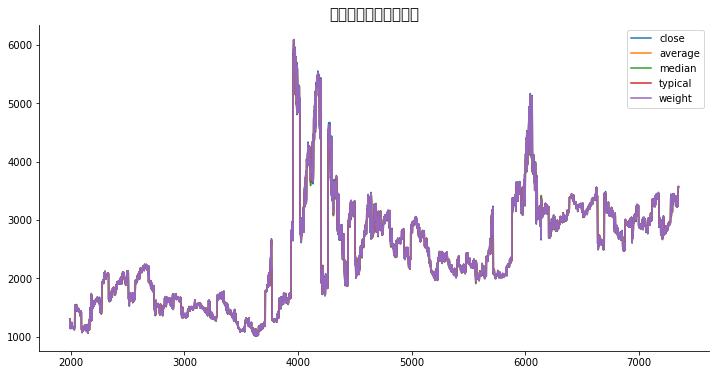

In [228]:
df1.loc['1990-12-19':,['close','average','median','typical','weight']].plot(figsize=(12,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数及其价格转换',fontsize=15)
plt.xlabel('')
#plt.show()

In [229]:
types=['SMA','EMA','WMA','DEMA','TEMA',
'TRIMA','KAMA','MAMA','T3']
for i in range(len(types)):
    df1[types[i]]=ta.MA(df1.close,timeperiod=5,matype=i)
df1.tail()

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,weight,SMA,EMA,WMA,DEMA,TEMA,TRIMA,KAMA,MAMA,T3
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,3493.694641,3344.392188,3358.126561,3361.540234,3405.215327,3433.612603,3322.445964,3307.899943,3272.038060,3318.784702
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,3517.686340,3379.054199,3414.976626,3422.968424,3484.269181,3518.003224,3358.211372,3329.329868,3400.357409,3362.712602
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,3542.920471,3430.711377,3460.276654,3480.242594,3536.671709,3563.896071,3438.086507,3378.645104,3413.398457,3415.565416
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,3563.807800,3482.668896,3498.919299,3528.740332,3575.611099,3593.958504,3502.725911,3422.763285,3421.538764,3469.127515
7347,3570.108154,3588.062500,3544.891113,3577.692383,3576.204590,-6.096400,-0.1705,345557888.0,5.020000e+11,3570.188538,...,3568.292480,3545.764941,3522.648918,3557.886751,3589.596530,3595.332008,3548.384386,3483.921928,3495.823459,3515.063131


Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 31181 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

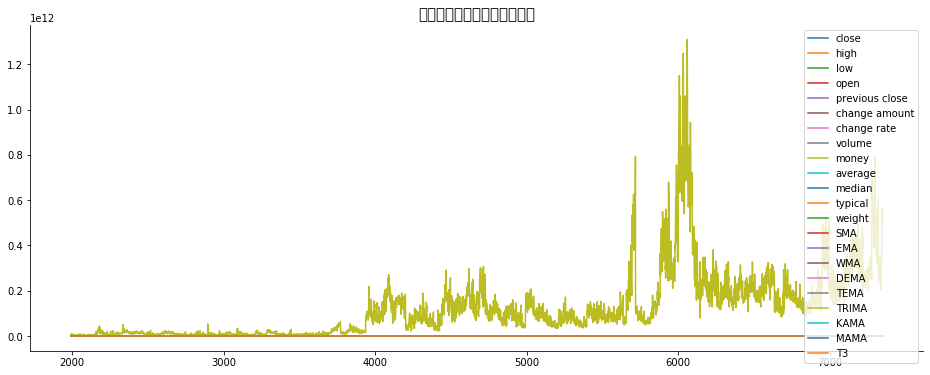

In [230]:
df1.loc['1990-12-19':].plot(figsize=(16,6))
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title('上证指数各种类型移动平均线',fontsize=15)
plt.xlabel('')
#plt.show()

In [231]:
#画5、30、120、250指数移动平均线
N=[5,30,120,250]
for i in N:
    df1['ma_'+str(i)]=ta.EMA(df1.close,timeperiod=i)
df1.tail()

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,DEMA,TEMA,TRIMA,KAMA,MAMA,T3,ma_5,ma_30,ma_120,ma_250
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,3405.215327,3433.612603,3322.445964,3307.899943,3272.038060,3318.784702,3358.126561,3310.938841,3198.255833,3122.826957
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,3484.269181,3518.003224,3358.211372,3329.329868,3400.357409,3362.712602,3414.976626,3324.986448,3203.717336,3126.060820
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,3536.671709,3563.896071,3438.086507,3378.645104,3413.398457,3415.565416,3460.276654,3339.560014,3209.455507,3129.445807
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,3575.611099,3593.958504,3502.725911,3422.763285,3421.538764,3469.127515,3498.919299,3354.827406,3215.517476,3133.005638
7347,3570.108154,3588.062500,3544.891113,3577.692383,3576.204590,-6.096400,-0.1705,345557888.0,5.020000e+11,3570.188538,...,3589.596530,3595.332008,3548.384386,3483.921928,3495.823459,3515.063131,3522.648918,3368.716486,3221.378479,3136.488527


Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 36208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21183 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

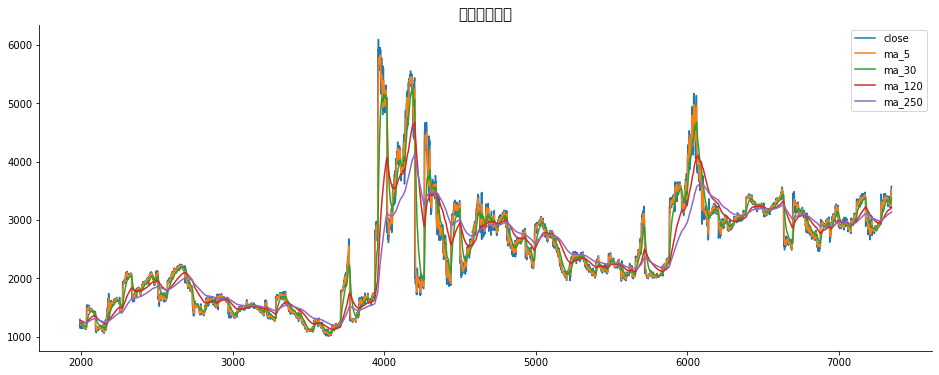

In [232]:
#画5、30、120、250指数移动平均线
df1.loc['1990-12-19':,['close','ma_5','ma_30','ma_120','ma_250']].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数走势',fontsize=15)
plt.xlabel('')
#plt.show()

In [233]:
H_line,M_line,L_line=ta.BBANDS(df1.close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df1['H_line']=H_line
df1['M_line']=M_line
df1['L_line']=L_line
df1.tail()

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,KAMA,MAMA,T3,ma_5,ma_30,ma_120,ma_250,H_line,M_line,L_line
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,3307.899943,3272.038060,3318.784702,3358.126561,3310.938841,3198.255833,3122.826957,3439.576237,3297.608655,3155.641072
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,3329.329868,3400.357409,3362.712602,3414.976626,3324.986448,3203.717336,3126.060820,3483.705732,3310.101807,3136.497881
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,3378.645104,3413.398457,3415.565416,3460.276654,3339.560014,3209.455507,3129.445807,3525.444927,3322.861670,3120.278412
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,3422.763285,3421.538764,3469.127515,3498.919299,3354.827406,3215.517476,3133.005638,3567.081873,3337.475684,3107.869494
7347,3570.108154,3588.062500,3544.891113,3577.692383,3576.204590,-6.096400,-0.1705,345557888.0,5.020000e+11,3570.188538,...,3483.921928,3495.823459,3515.063131,3522.648918,3368.716486,3221.378479,3136.488527,3600.946052,3352.459338,3103.972625


Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 26519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

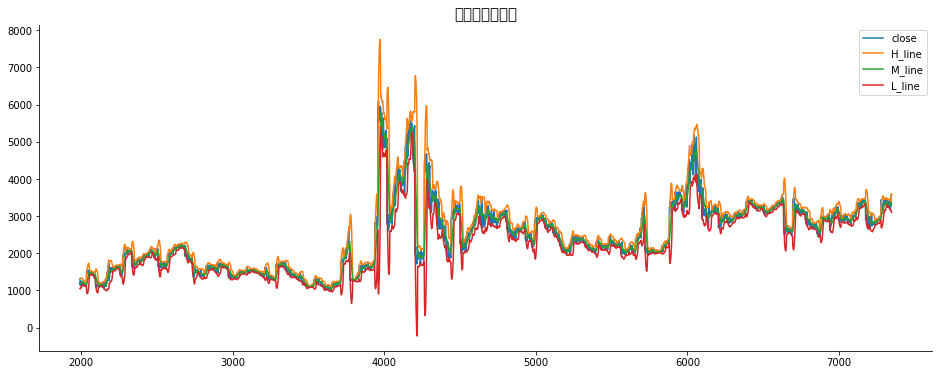

In [234]:
df1.loc['1990-12-19':,['close','H_line','M_line','L_line']].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数布林线',fontsize=15)
plt.xlabel('')
#plt.show()

In [235]:
df1['HT']=ta.HT_TRENDLINE(df1.close)
periods =np.array([3]*len(df1), dtype=float)
df1['MAVP']=ta. MAVP(df1.close,periods)
df1['MIDPOINT']=ta.MIDPOINT(df1.close)
df1['MIDPRICE']=ta.MIDPRICE(df1.high,df1.low)
df1['SAR']=ta.SAR(df1.high,df1.low)
df1['SAREXT']=ta.SAREXT(df1.high,df1.low)
df1.tail()

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,ma_250,H_line,M_line,L_line,HT,MAVP,MIDPOINT,MIDPRICE,SAR,SAREXT
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,3122.826957,3439.576237,3297.608655,3155.641072,3284.417729,3358.001139,3360.246582,3356.999512,3202.343506,3202.343506
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,3126.060820,3483.705732,3310.101807,3136.497881,3294.188815,3428.754395,3373.105713,3365.510132,3208.529746,3208.529746
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,3129.445807,3525.444927,3322.861670,3120.278412,3313.667616,3527.503988,3384.205688,3379.572876,3221.335627,3221.335627
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,3133.005638,3567.081873,3337.475684,3107.869494,3339.831333,3551.919352,3396.869629,3389.274048,3241.463624,3241.463624
7347,3570.108154,3588.062500,3544.891113,3577.692383,3576.204590,-6.096400,-0.1705,345557888.0,5.020000e+11,3570.188538,...,3136.488527,3600.946052,3352.459338,3103.972625,3368.411125,3565.729818,3396.869629,3395.203003,3268.242901,3268.242901


Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20854 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

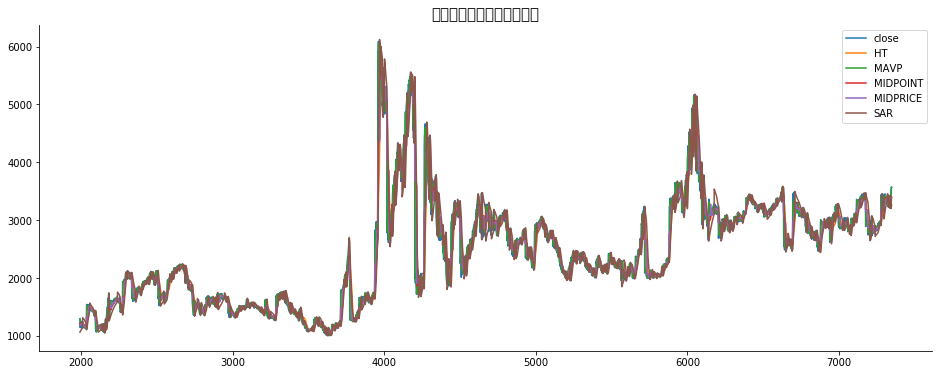

In [236]:
df1.loc['1990-12-19':,['close','HT','MAVP','MIDPOINT','MIDPRICE','SAR']].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数的其他趋势指标线',fontsize=15)
plt.xlabel('')
#plt.show()

Text(0.5, 0, '')

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25351 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-package

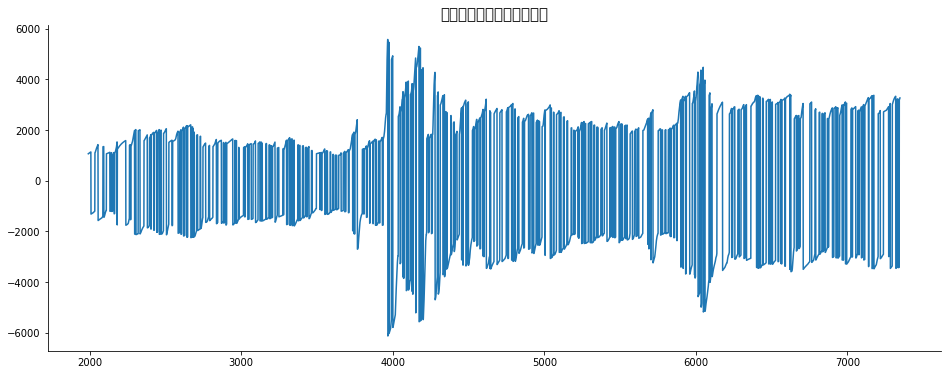

In [237]:
df1.loc['1990-12-19':,'SAREXT'].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数的抛物线扩展走势',fontsize=15)
plt.xlabel('')
#plt.show()

In [238]:
df1['dcperiod']=ta.HT_DCPERIOD(df1.close)
df1['dcphase']=ta.HT_DCPHASE(df1.close)
df1['inhpase'],df1['quadrature']=ta.HT_PHASOR(df1.close)
df1['sine'],df1['leadsine']=sine, leadsine = ta.HT_SINE(df1.close)
df1['trendmode']=ta.HT_TRENDMODE(df1.close)

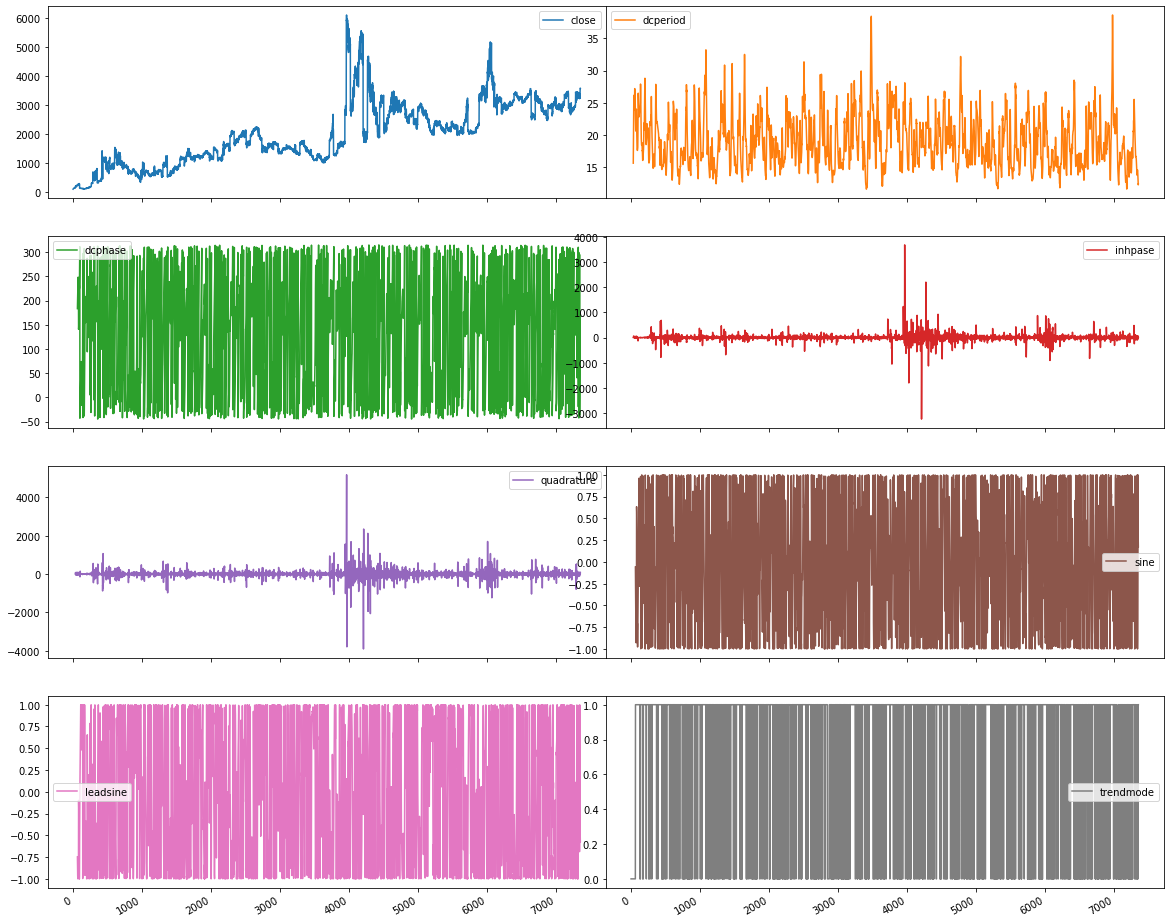

In [239]:
#将上述函数计算得到的结果进行可视化
df1[['close','dcperiod','dcphase','inhpase','quadrature','sine','leadsine','trendmode']].plot(figsize=(20,18),
       subplots = True,layout=(4, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

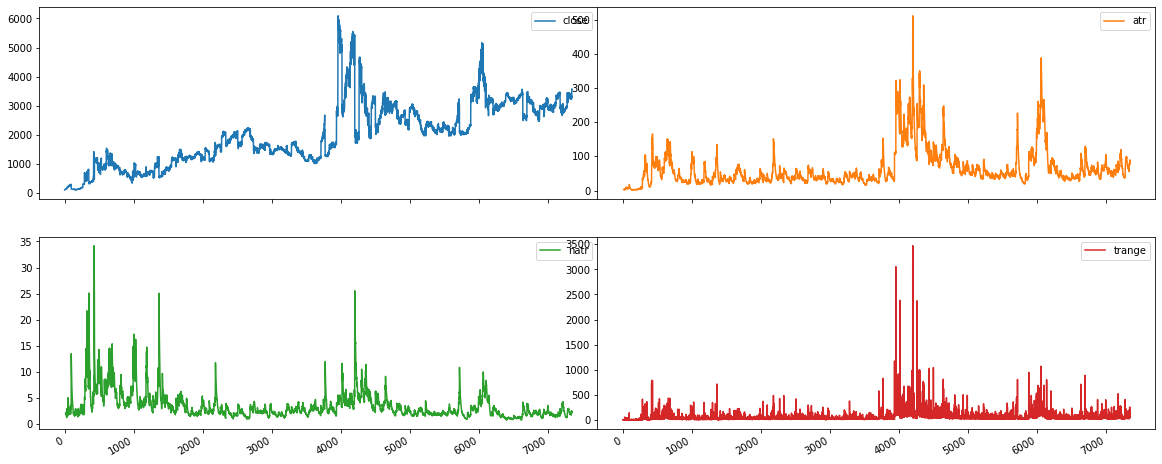

In [240]:
df1['atr']=ta.ATR(df1.high, df1.low, df1.close, timeperiod=14)
df1['natr']=ta.NATR(df1.high, df1.low, df1.close, timeperiod=14)
df1['trange']=ta.TRANGE(df1.high, df1.low, df1.close)
df1.tail()
df1[['close','atr','natr','trange']].plot(figsize=(20,18),
       subplots = True,layout=(4, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

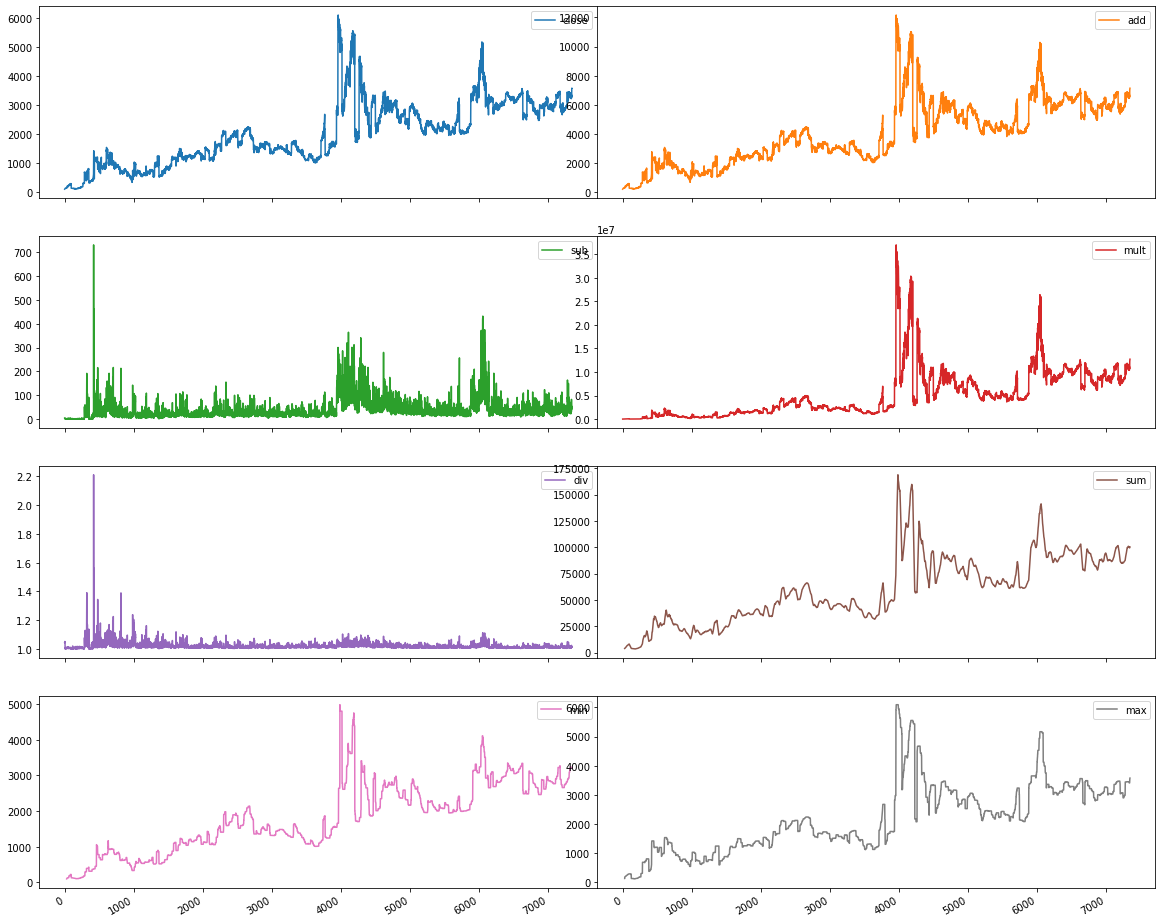

In [241]:
df1['add']=ta.ADD(df1.high,df1.low)
#最高价与最低价之差
df1['sub']=ta.SUB(df1.high,df1.low)
#最高价与最低价之乘
df1['mult']=ta.MULT(df1.high,df1.low)
#最高价与最低价之除
df1['div']=ta.DIV(df1.high,df1.low)
#收盘价的每30日移动求和
df1['sum']=ta.SUM(df1.close, timeperiod=30)
#收盘价的每30日内的最大最小值
df1['min'], df1['max'] = ta.MINMAX(df1.close, timeperiod=30)
#收盘价的每30日内的最大最小值对应的索引值（第N行）
df1['minidx'], df1['maxidx'] = ta.MINMAXINDEX(df1.close, timeperiod=30)
df1.tail()

#将上述函数计算得到的结果进行可视化
df1[['close','add','sub','mult','div','sum','min','max']].plot(figsize=(20,18),
       subplots = True,
       layout=(4, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

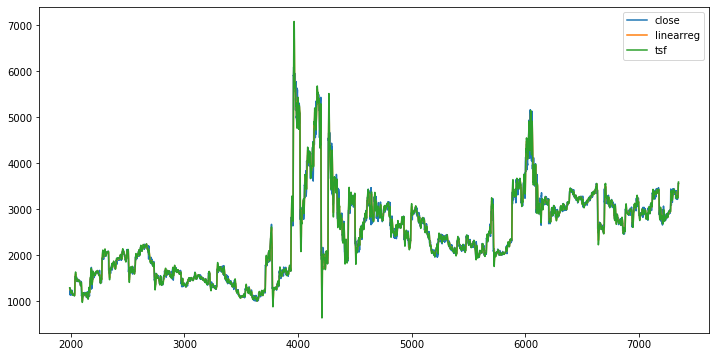

In [242]:
#收盘价对时间t的线性回归预测值
df1['linearreg']=ta.LINEARREG(df1.close, timeperiod=14)
#时间序列预测值
df1['tsf']=ta.TSF(df1.close, timeperiod=14)
#画图
df1.loc['1990-12-19':,['close','linearreg','tsf']].plot(figsize=(12,6))

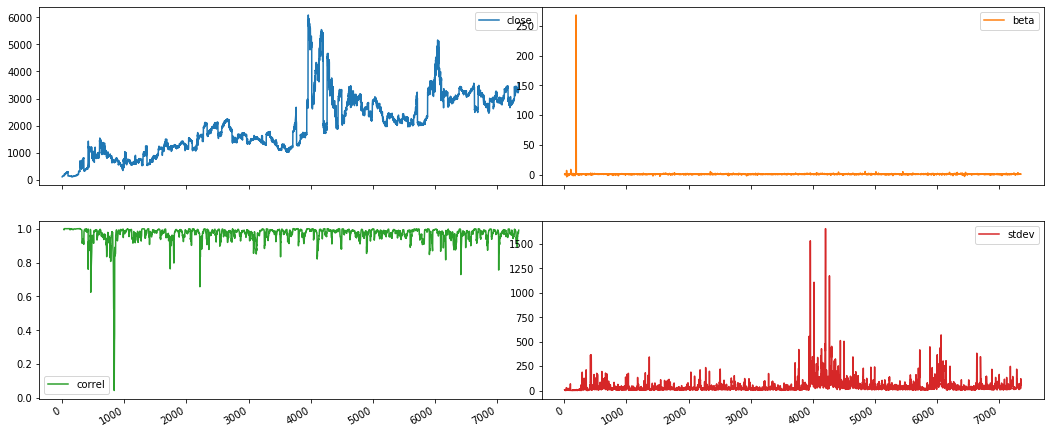

In [243]:
df1['beta']=ta.BETA(df1.high,df1.low,timeperiod=5)
df1['correl']=ta.CORREL(df1.high, df1.low, timeperiod=30)
df1['stdev']=ta.STDDEV(df1.close, timeperiod=5, nbdev=1)
#将上述函数计算得到的结果进行可视化
df1[['close','beta','correl','stdev']].plot(figsize=(18,8),
       subplots = True,layout=(2, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

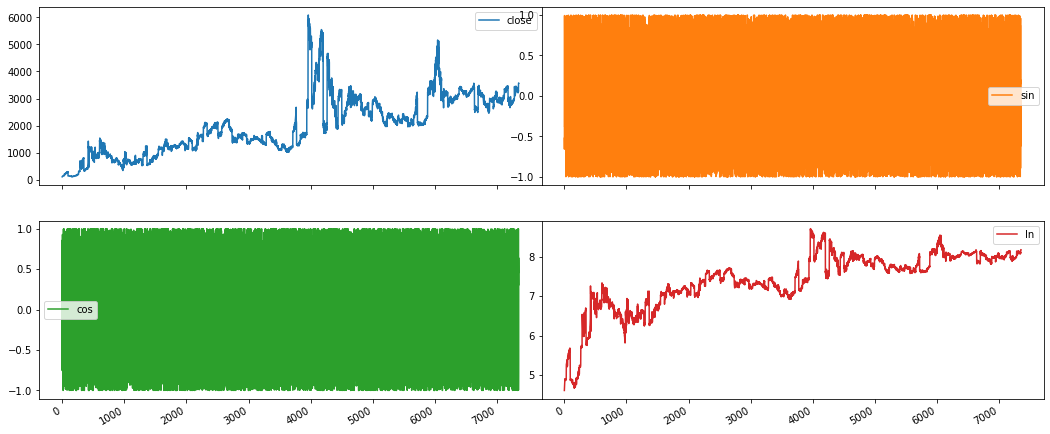

In [244]:
df1['sin']=ta.SIN(df1.close)
df1['cos']=ta.COS(df1.close)
df1['ln']=ta.LN(df1.close)
#将上述函数计算得到的结果进行可视化
df1[['close','sin','cos','ln']].plot(figsize=(18,8),
       subplots = True,layout=(2, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

In [245]:
df1

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,minidx,maxidx,linearreg,tsf,beta,correl,stdev,sin,cos,ln
0,99.980003,99.980003,95.790001,96.050003,99.980003,4.410000,4.4109,1260.0,4.940000e+05,97.950003,...,0,0,NaN,NaN,NaN,NaN,NaN,-0.523507,0.852022,4.604970
1,104.389999,104.389999,99.980003,104.300003,99.980003,4.410000,4.4109,197.0,8.400000e+04,103.265001,...,0,0,NaN,NaN,NaN,NaN,NaN,-0.657459,-0.753490,4.648134
2,109.129997,109.129997,103.730003,109.070000,104.389999,4.740000,4.5407,28.0,1.600000e+04,107.764999,...,0,0,NaN,NaN,NaN,NaN,NaN,0.735054,-0.678009,4.692540
3,114.550003,114.550003,109.129997,113.570000,109.129997,5.420000,4.9666,32.0,3.100000e+04,112.950001,...,0,0,NaN,NaN,NaN,NaN,NaN,0.993031,0.117854,4.741011
4,120.250000,120.250000,114.550003,120.089996,114.550003,5.700000,4.9760,15.0,6.000000e+03,118.785000,...,0,0,NaN,NaN,NaN,NaN,7.180757,0.763993,0.645225,4.789573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,7335,7343,3346.603104,3355.086777,1.003868,0.978372,85.775672,-0.082593,-0.996583,8.161363
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,7335,7344,3411.241302,3427.342481,0.974400,0.983315,113.684139,-0.619580,-0.784933,8.168678
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,7335,7345,3469.447789,3491.464524,0.942637,0.986698,121.099262,0.768831,0.639452,8.174950
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,7335,7346,3527.037716,3554.656263,1.003115,0.988888,116.560976,0.878231,0.478237,8.182057


In [246]:
#计算得出标签
record=(df1['change amount'][0:].values)>0
classification=[]
for i in record:
    if(i==True):
        classification.append(1)
    else:
        classification.append(0)
classification
df1['label']=classification    
df1

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,maxidx,linearreg,tsf,beta,correl,stdev,sin,cos,ln,label
0,99.980003,99.980003,95.790001,96.050003,99.980003,4.410000,4.4109,1260.0,4.940000e+05,97.950003,...,0,NaN,NaN,NaN,NaN,NaN,-0.523507,0.852022,4.604970,1
1,104.389999,104.389999,99.980003,104.300003,99.980003,4.410000,4.4109,197.0,8.400000e+04,103.265001,...,0,NaN,NaN,NaN,NaN,NaN,-0.657459,-0.753490,4.648134,1
2,109.129997,109.129997,103.730003,109.070000,104.389999,4.740000,4.5407,28.0,1.600000e+04,107.764999,...,0,NaN,NaN,NaN,NaN,NaN,0.735054,-0.678009,4.692540,1
3,114.550003,114.550003,109.129997,113.570000,109.129997,5.420000,4.9666,32.0,3.100000e+04,112.950001,...,0,NaN,NaN,NaN,NaN,NaN,0.993031,0.117854,4.741011,1
4,120.250000,120.250000,114.550003,120.089996,114.550003,5.700000,4.9760,15.0,6.000000e+03,118.785000,...,0,NaN,NaN,NaN,NaN,7.180757,0.763993,0.645225,4.789573,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7343,3502.958496,3511.655518,3457.206055,3474.679199,3473.069336,29.889099,0.8606,380790784.0,5.230000e+11,3486.624817,...,7343,3346.603104,3355.086777,1.003868,0.978372,85.775672,-0.082593,-0.996583,8.161363,1
7344,3528.676758,3528.676758,3484.715088,3492.191162,3502.958496,25.718300,0.7342,407995936.0,5.680000e+11,3508.564941,...,7344,3411.241302,3427.342481,0.974400,0.983315,113.684139,-0.619580,-0.784933,8.168678,1
7345,3550.876709,3556.802246,3513.126221,3530.907227,3528.676758,22.200001,0.6291,370230912.0,5.220000e+11,3537.928101,...,7345,3469.447789,3491.464524,0.942637,0.986698,121.099262,0.768831,0.639452,8.174950,1
7346,3576.204590,3576.204590,3526.617432,3552.908691,3550.876709,25.327900,0.7133,405348224.0,5.460000e+11,3557.983826,...,7346,3527.037716,3554.656263,1.003115,0.988888,116.560976,0.878231,0.478237,8.182057,1


In [247]:
#进行数据归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df1 = pd.DataFrame(df0, columns=df1.columns)
df1

,close,high,low,open,previous close,change amount,change rate,volume,money,average,...,maxidx,linearreg,tsf,beta,correl,stdev,sin,cos,ln,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.357598,0.171002,1.452517e-06,3.725191e-07,0.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,0.238246,0.926011,0.000000,1.0
1,0.000736,0.000732,0.000705,0.001384,0.000000,0.357598,0.171002,2.123358e-07,5.954198e-08,0.000889,...,0.000000,NaN,NaN,NaN,NaN,NaN,0.171270,0.123255,0.010503,1.0
2,0.001527,0.001519,0.001336,0.002184,0.000736,0.357926,0.172069,1.516684e-08,7.633588e-09,0.001641,...,0.000000,NaN,NaN,NaN,NaN,NaN,0.867527,0.160995,0.021308,1.0
3,0.002432,0.002419,0.002244,0.002939,0.001527,0.358604,0.175570,1.983357e-08,1.908397e-08,0.002508,...,0.000000,NaN,NaN,NaN,NaN,NaN,0.996516,0.558927,0.033102,1.0
4,0.003383,0.003365,0.003156,0.004033,0.002432,0.358882,0.175647,0.000000e+00,0.000000e+00,0.003484,...,0.000000,NaN,NaN,NaN,NaN,0.004207,0.881997,0.822612,0.044918,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7343,0.567913,0.566341,0.565426,0.566753,0.562925,0.382971,0.141821,4.442611e-01,3.992366e-01,0.566622,...,0.999592,0.486927,0.467690,0.016875,0.977389,0.051661,0.458703,0.001708,0.865351,1.0
7344,0.572205,0.569167,0.570054,0.569691,0.567913,0.378817,0.140782,4.760008e-01,4.335878e-01,0.570290,...,0.999728,0.496598,0.478002,0.016766,0.982564,0.068512,0.190209,0.107533,0.867131,1.0
7345,0.575910,0.573836,0.574833,0.576185,0.572205,0.375314,0.139918,4.319411e-01,3.984733e-01,0.575200,...,0.999864,0.505307,0.487153,0.016649,0.986104,0.072989,0.884415,0.819726,0.868657,1.0
7346,0.580137,0.577056,0.577102,0.579876,0.575910,0.378429,0.140610,4.729118e-01,4.167939e-01,0.578554,...,1.000000,0.513924,0.496171,0.016872,0.988397,0.070249,0.939115,0.739119,0.870386,1.0


In [248]:
X = df1.iloc[1:,3:]
print(X)
y=df1.shift(1)
y=y.loc[:,'label'].dropna(inplace=False)
print(y)


          open  previous close  change amount  change rate        volume  \
1     0.001384        0.000000       0.357598     0.171002  2.123358e-07   
2     0.002184        0.000736       0.357926     0.172069  1.516684e-08   
3     0.002939        0.001527       0.358604     0.175570  1.983357e-08   
4     0.004033        0.002432       0.358882     0.175647  0.000000e+00   
5     0.004902        0.003383       0.358205     0.169060  9.916783e-08   
...        ...             ...            ...          ...           ...   
7343  0.566753        0.562925       0.382971     0.141821  4.442611e-01   
7344  0.569691        0.567913       0.378817     0.140782  4.760008e-01   
7345  0.576185        0.572205       0.375314     0.139918  4.319411e-01   
7346  0.579876        0.575910       0.378429     0.140610  4.729118e-01   
7347  0.584033        0.580137       0.347135     0.133346  4.031556e-01   

             money   average    median   typical    weight  ...    maxidx  \
1     5.95

In [255]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.4,
          'bagging_fraction': 0.8,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 12,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'num_threads':4,
          'n_estimators':10000
         }

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
dtrain = lgb.Dataset(X_train, y_train, params=params)
dvalid = lgb.Dataset(X_test, y_test, params=params, reference=dtrain)
gbm = lgb.train(params, dtrain, 100000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=200)
feature_importances = pd.DataFrame()
feature_importances = gbm.feature_importance()
features = pd.DataFrame({'feature':X.columns,'feature_importances':feature_importances})
print(features)

predict = gbm.predict(X_test)
y_pred_class = [0 if x < 0.5 else 1 for x in predict]
ligntgbm_score = accuracy_score(y_test, y_pred_class)
print("%s模型: %.3f" % ('ligntgbm_', ligntgbm_score))

[LightGBM] [Warning] num_iterations is set=10000, n_estimators=10000 will be ignored. Current value: num_iterations=10000
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.832847	valid_1's auc: 0.642896
Early stopping, best iteration is:
[116]	training's auc: 0.800831	valid_1's auc: 0.646773
           feature  feature_importances
0             open                   55
1   previous close                   20
2    change amount                  211
3      change rate                  207
4           volume                  308
5            money                  312
6          average                   18
7           median                    6
8          typical                   17
9           weight                   15
10             SMA                   14
11             EMA                    6
12             WMA                   14
13            DEMA                   18
14            TEMA                   23
15           TRIMA             